In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ON BOTH FILES THERE IS DATA MIXED
#SUCCESS - W_* with excuting time
#DELAYS -  W_* with no excuting time, but transition time is greater than a second
#FILLERS - W_* with no excuting time or transition time

df1 = pd.read_csv('w_validate_application_wrapper.csv', delimiter=',', index_col=0, encoding='utf-8-sig')
df2 = pd.read_csv('w_validate_application_instantaneous.csv', delimiter=',', index_col=0,encoding='utf-8-sig')

#df1 - SUCCESS + DELAYS
#df2 - FILLERS + DELAYS
print df1.shape, df2.shape

(113437, 7) (2397, 7)


In [2]:
#df3 - DELAYS
df3 = df1.drop_duplicates(subset='Case ID', keep=False)
successindex = df1.index.difference(df3.index)
df1 = df1.loc[successindex,:]

print df1.shape,df2.shape,df3.shape

(113437, 7) (2397, 7) (0, 7)


In [3]:
df3.head()

Empty DataFrame
Columns: [Case ID, Activity, Start Timestamp, Complete Timestamp, Delta Trans, Delta Exec, Delta]
Index: []

In [4]:
df2.head()

Case ID                Activity          Start Timestamp  \
47    Application_428409768  W_Validate application  2016/01/13 06:57:21.342   
328  Application_2082119944  W_Validate application  2016/01/14 06:20:43.409   
343   Application_758985626  W_Validate application  2016/01/22 08:00:58.783   
405  Application_1846626914  W_Validate application  2016/01/13 06:24:48.318   
422   Application_546206358  W_Validate application  2016/01/08 06:35:59.783   

          Complete Timestamp                 Delta Trans  \
47   2016/01/13 06:57:21.342  10 days 21:31:02.202000000   
328  2016/01/14 06:20:43.409  10 days 00:09:17.819000000   
343  2016/01/22 08:00:58.783  16 days 01:02:57.842000000   
405  2016/01/13 06:24:48.318   8 days 23:22:41.138000000   
422  2016/01/08 06:35:59.783   4 days 00:17:48.880000000   

                    Delta Exec                       Delta  
47   0 days 00:00:00.000000000  10 days 21:31:02.202000000  
328  0 days 00:00:00.000000000  10 days 00:09:17.819000000  
343  0 days 00:00:00.000000000  16 days 01:02:57.842000000  
405  0 days 00:00:00.000000000   8 days 23:22:41.138000000  
422  0 days 00:00:00.000000000   4 days 00:17:48.880000000

In [5]:
# MOVE DELAYS FROM DF 2
delayindex = pd.to_timedelta(df2['Delta']) > pd.Timedelta('1 Second')
df3 = pd.concat((df3,df2[delayindex]),axis=0)
df2 = df2[~delayindex]

print df1.shape, df2.shape, df3.shape

(113437, 7) (0, 7) (2397, 7)


In [6]:
df1["Status"] = 1 # success
df2["Status"] = 2 # filler
df3["Status"] = 3 # delay


df = pd.concat((df1,df2,df3),axis=0)


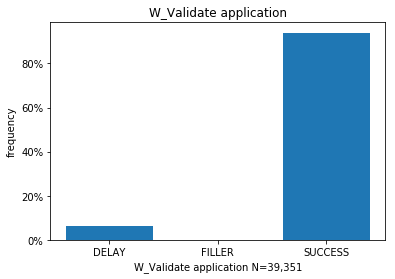

In [7]:
# build a frequency barchart for each category
N = df.shape[0]
M = df[df['Activity'] == 'W_Validate application'].shape[0]
activitydf = df[df['Activity'] == 'W_Validate application']
df1 = activitydf[activitydf['Status'] == 1]
df2 = activitydf[activitydf['Status'] == 2]
df3 = activitydf[activitydf['Status'] == 3]

success = float(df1.shape[0]) / M
filler  = float(df2.shape[0]) / M
delay   = float(df3.shape[0]) / M


D = {u'SUCCESS':success*100, u'DELAY': delay*100, u'FILLER':filler*100}

xlabel = "W_Validate application N=%s"%("{:,}".format(M))

fig, ax = plt.subplots()
plt.title('W_Validate application')
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())
plt.xlabel(xlabel)
plt.ylabel("frequency")
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)



plt.show()

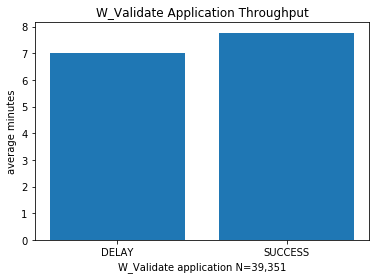

In [8]:
# build a time spent
# print df1.shape
# print pd.to_timedelta(df1['Delta']).dt.total_seconds().sum()
# print df1.loc[:36953,'Delta']
success = pd.to_timedelta(df1['Delta']).dt.total_seconds().sum() / df1['Delta'].shape[0]
# filler  = pd.to_timedelta(df2['Delta']).sum() / df2['Delta'].shape[0]
delay   = pd.to_timedelta(df3['Delta']).dt.total_seconds().sum() / df3['Delta'].shape[0]

days, remainder = divmod(success, 3600*24)
hours, remainder = divmod(remainder, 3600)
minutes, seconds = divmod(remainder, 60)

success = days + hours/24 + minutes/60 + seconds/3600

# print success
days, remainder = divmod(delay, 3600*24)
hours, remainder = divmod(days, 3600)
minutes, seconds = divmod(remainder, 60)

delay = days + hours/24 + minutes/60 + seconds/3600

# print delay


D = {u'SUCCESS':success, u'DELAY': delay}
plt.title('W_Validate Application Throughput')
plt.xlabel(xlabel)
plt.ylabel("average minutes")

plt.bar(range(len(D)), D.values(), align='center', width=0.8)
plt.xticks(range(len(D)), D.keys())
plt.show()

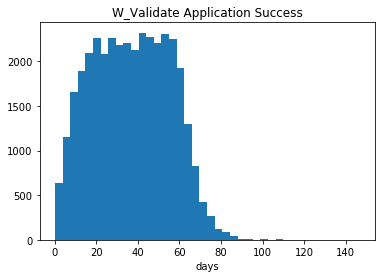

In [9]:
# Histogram of success per minute
success =  pd.to_timedelta(df1['Delta']) / np.timedelta64(1, 's')
# x = np.zeros(success.shape)
# for i,suc in success.itertools:
days, remainder = divmod(success, 3600*24)
hours, remainder = divmod(remainder, 3600)
minutes, seconds = divmod(remainder, 60)
x = days + hours/24 + minutes/(24*60) + seconds
#    x x[i] = days + hours/24 + minutes/(24*60) + seconds

# print divmod(success, 3600)

plt.title('W_Validate Application Success')
plt.xlabel('days')
plt.hist(x, bins=40)
plt.show()


In [10]:
#Wrapped events
df4 = df[(~(df['Activity'] == 'W_Validate application')) & (df["Status"]==1)] 
df4.loc[:,['Delta Trans','Delta Exec','Delta']] = df4.loc[:,['Delta Trans','Delta Exec','Delta']].apply(pd.to_timedelta)
print df4.head()


                   Case ID      Activity          Start Timestamp  \
11   Application_652823628  A_Validating  2016/01/13 11:10:55.973   
16   Application_652823628  A_Validating  2016/01/14 11:39:51.556   
30  Application_1691306052  A_Validating  2016/01/07 07:40:09.412   
31  Application_1691306052      A_Denied  2016/01/07 11:29:49.671   
32  Application_1691306052     O_Refused  2016/01/07 11:29:49.710   

         Complete Timestamp     Delta Trans Delta Exec           Delta  Status  
11  2016/01/13 11:10:55.973 00:00:00.828000     0 days 00:00:00.828000       1  
16  2016/01/14 11:39:51.556 00:00:00.062000     0 days 00:00:00.062000       1  
30  2016/01/07 07:40:09.412 00:00:00.852000     0 days 00:00:00.852000       1  
31  2016/01/07 11:29:49.671 03:49:40.259000     0 days 03:49:40.259000       1  
32  2016/01/07 11:29:49.710 00:00:00.039000     0 days 00:00:00.039000       1  


/Users/Varela/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(15,)


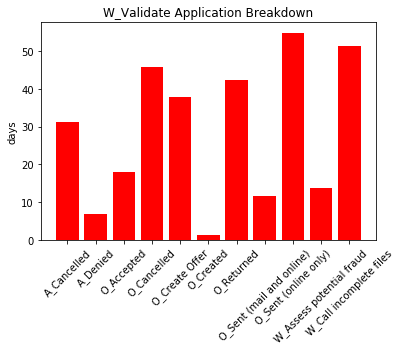

In [15]:
sumdeltasdf = pd.pivot_table(df4, values=['Delta'],columns=['Activity'], aggfunc=np.sum)
numdf       = pd.pivot_table(df4, values=['Delta'],columns=['Activity'], aggfunc=len)
columns     = sumdeltasdf.columns

print columns.shape

l = len(columns.tolist())

x =  (sumdeltasdf.values / np.timedelta64(1, 's'))/ numdf.values
days, remainder = divmod(x, 3600*24)
hours, remainder = divmod(remainder, 3600)
minutes, seconds = divmod(remainder, 60)
x = days + hours/24 + minutes/(24*60) + seconds
x = x.reshape((l,))

#Prevent zeros from polluting
threshold =1
ind = x > threshold
xthresh = x[ind] 
columnsthresh = columns[np.where(ind)]
# xthresh = x
# columnsthresh = columns
plt.title('W_Validate Application Breakdown')


plt.bar(range(len(columnsthresh)), xthresh.T, align='center', color='red')
plt.xticks(range(len(columnsthresh)), columnsthresh,rotation=45)
plt.ylabel('days')
plt.show()



